<a href="https://colab.research.google.com/github/YinGuoX/Deep_Learning_Keras_WithDeeplizard/blob/master/17_MobileNet_Image_Classification_With_TensorFlow's_Keras_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MobileNet Image Classification With TensorFlow's Keras API

在本集中，我们将介绍MobileNets，这是一类轻量级的深度卷积神经网络，与许多其他流行的模型相比，它们的体积小得多，性能更快。 我们还将看到如何使用TensorFlow的Keras API在代码中使用MobileNets。

MobileNets是一类小型，低延迟，低功耗的模型，可用于分类，检测和卷积神经网络最适合的其他常见任务。 由于它们的体积小，它们被认为是在移动设备上使用的出色的深度学习模型。

## 1.将MobileNets与其他模型进行比较
为了快速比较大小，磁盘上整个VGG16网络的大小约为553兆字节。 当前最大的MobileNet之一的大小约为17兆字节，这是一个巨大的差异，尤其是当您考虑将模型部署到移动应用程序或在浏览器中运行该模型时

巨大的尺寸差异是由于这些网络中的参数数量所致。 例如，VGG16有1.38亿个参数，而我们刚才提到的17兆字节的MobileNet只有420万。

除了磁盘上网络的大小外，内存中网络的大小也会随着网络参数数量的增加而增加。 在以后的几集中，我们将测试并演示这些模型之间的性能差异，因此请继续关注。

现在，虽然MobileNets比其他主要网络（例如VGG16）更快，更小，但还是需要权衡取舍。 这种权衡是准确的，但不要因此而灰心。

是的，MobileNets通常不如其他大型的，占用大量资源的模型那样准确，但是它们实际上仍然表现出色，但准确率的降低幅度相对较小。 如果您有兴趣进一步研究此内容，那么这是一份[MobileNets](https://arxiv.org/pdf/1704.04861.pdf)论文，它进一步阐述了这种折衷方案。

现在，让我们看看如何开始在Keras中使用MobileNets。

## 2.部署MobileNets

首先，我们将导入在接下来的几个MobileNet中将要使用的所有第三方库。

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

我们要做的是下载MobileNet模型，然后将其用于推断一些随机图像，以查看其如何根据ImageNet类对这些图像进行分类。

我们首先调用tf.keras.applications.mobilenet.MobileNet（）以获取单个预训练MobileNet的副本，该副本具有从ImageNet图像上进行训练所得到的权重。 我们将此模型分配给变量mobile。

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()
# help(tf.keras.applications.mobilenet_v3())
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

接下来，我们有一个称为prepare_image（）的函数，该函数接受图像文件，并处理该图像以模型期望的格式获取它。 我们将在使用MobileNet对其进行预测之前将每张图像传递给该函数，因此，让我们看看该函数到底在做什么。

In [ ]:
# 在colab上使用的云端数据
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = "/content/drive/My Drive/DeepLearning_AI_Course/Deeplizard/Keras - Python Deep Learning Neural Network API/Data"

# 更改当前系统的路径
os.chdir(path)
# 显示当前路径的文件夹名字
print(os.listdir())

# 获得当前路径
os.getcwd()

['dogs-vs-cats', 'MobileNet-samples']


'/content/drive/My Drive/DeepLearning_AI_Course/Deeplizard/Keras - Python Deep Learning Neural Network API/Data'

In [ ]:
def prepare_image(file):
    img_path = './MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

在此函数中，我们首先定义图像的相对路径。 我将要使用的所有示例图像都存储在/MobileNet-samples中。

然后，我们调用Keras函数image.load_img（），它接受图像文件和图像的target_size，我们将其设置为（224,224）（这是MobileNet的默认大小）。 load_img（）返回PIL图像的实例。

然后，我们使用Keras img_to_array（）函数将PIL图片转换为数组，然后使用numpy的expand_dims（）扩展该数组的尺寸。

最后，我们从tf.keras.applications.mobilenet调用preprocess_input（），该处理程序将给定的图像数据预处理为与最初训练MobileNet的图像相同的格式。 具体来说，它会在-1和1之间缩放图像中的像素值，此函数将以numpy数组的形式返回经过预处理的图像数据。

这个结果就是我们在整个prepare_image（）函数中返回的结果。

## 3. 使用MobileNet进行预测
现在让我们从MobileNet得到一些预测，看看它的表现如何。我们将使用一些随机的样本图像。

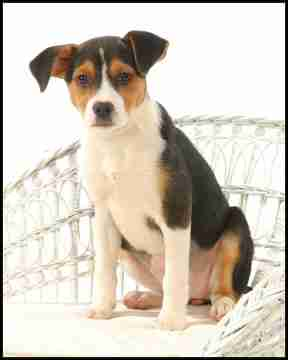

In [ ]:
from IPython.display import Image
Image(filename='./MobileNet-samples/1.jpg', width=300,height=200) 

我们将通过将其传递给prepare_image（）函数来处理该图像，并将结果分配给此preprocessed_image变量。 然后，我们通过调用mobile.predict（）并将其传递给我们的preprocessed_image来使MobileNet对该图像进行预测。

In [ ]:
preprocessed_image = prepare_image('1.jpg')
predictions = mobile.predict(preprocessed_image)

然后，我们使用由Keras提供的ImageNet工具函数，称为decode_predictions（）。 它返回具有ImageNet类ID，类标签和概率的前五个ImageNet类预测。 这样，我们就可以在给定图像上从我们的模型中看到五个具有最高预测概率的ImageNet类。 (回想一下，总共有1000个ImageNet类。)

In [ ]:
results = imagenet_utils.decode_predictions(predictions)

40960/35363 [==================================] - 0s 0us/step


In [ ]:
print(results)

[[('n02108000', 'EntleBucher', 0.53184235), ('n02107908', 'Appenzeller', 0.25463986), ('n02089973', 'English_foxhound', 0.13724467), ('n02089867', 'Walker_hound', 0.018917678), ('n02088364', 'beagle', 0.014333282)]]


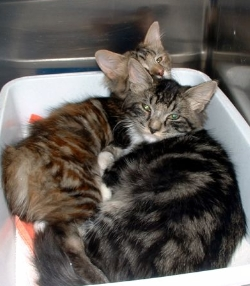

In [ ]:
from IPython.display import Image
Image(filename='./MobileNet-samples/2.jpg', width=300,height=200) 

In [ ]:
preprocessed_image = prepare_image('2.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
print(results)

[[('n04553703', 'washbasin', 0.7028701), ('n02123045', 'tabby', 0.07186853), ('n04554684', 'washer', 0.054263238), ('n02124075', 'Egyptian_cat', 0.038390465), ('n03642806', 'laptop', 0.026495874)]]


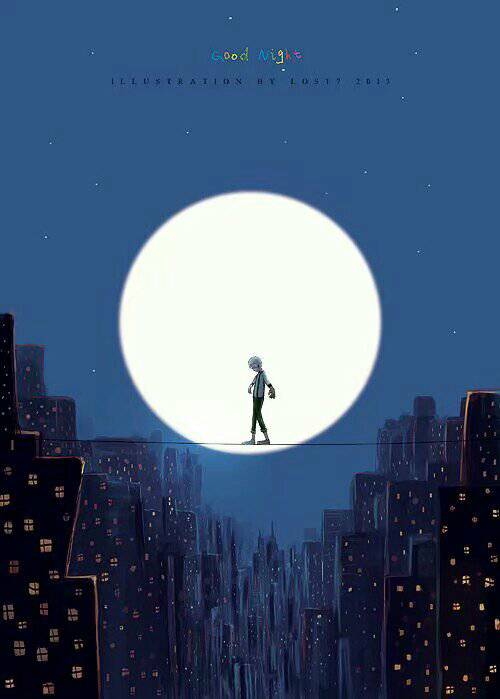

In [ ]:
from IPython.display import Image
Image(filename='./MobileNet-samples/3.jpg', width=300,height=200) 

In [ ]:
preprocessed_image = prepare_image('3.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
print(results)

[[('n04044716', 'radio_telescope', 0.5369115), ('n04258138', 'solar_dish', 0.062801994), ('n03691459', 'loudspeaker', 0.054491818), ('n02708093', 'analog_clock', 0.038091376), ('n03388043', 'fountain', 0.020083245)]]


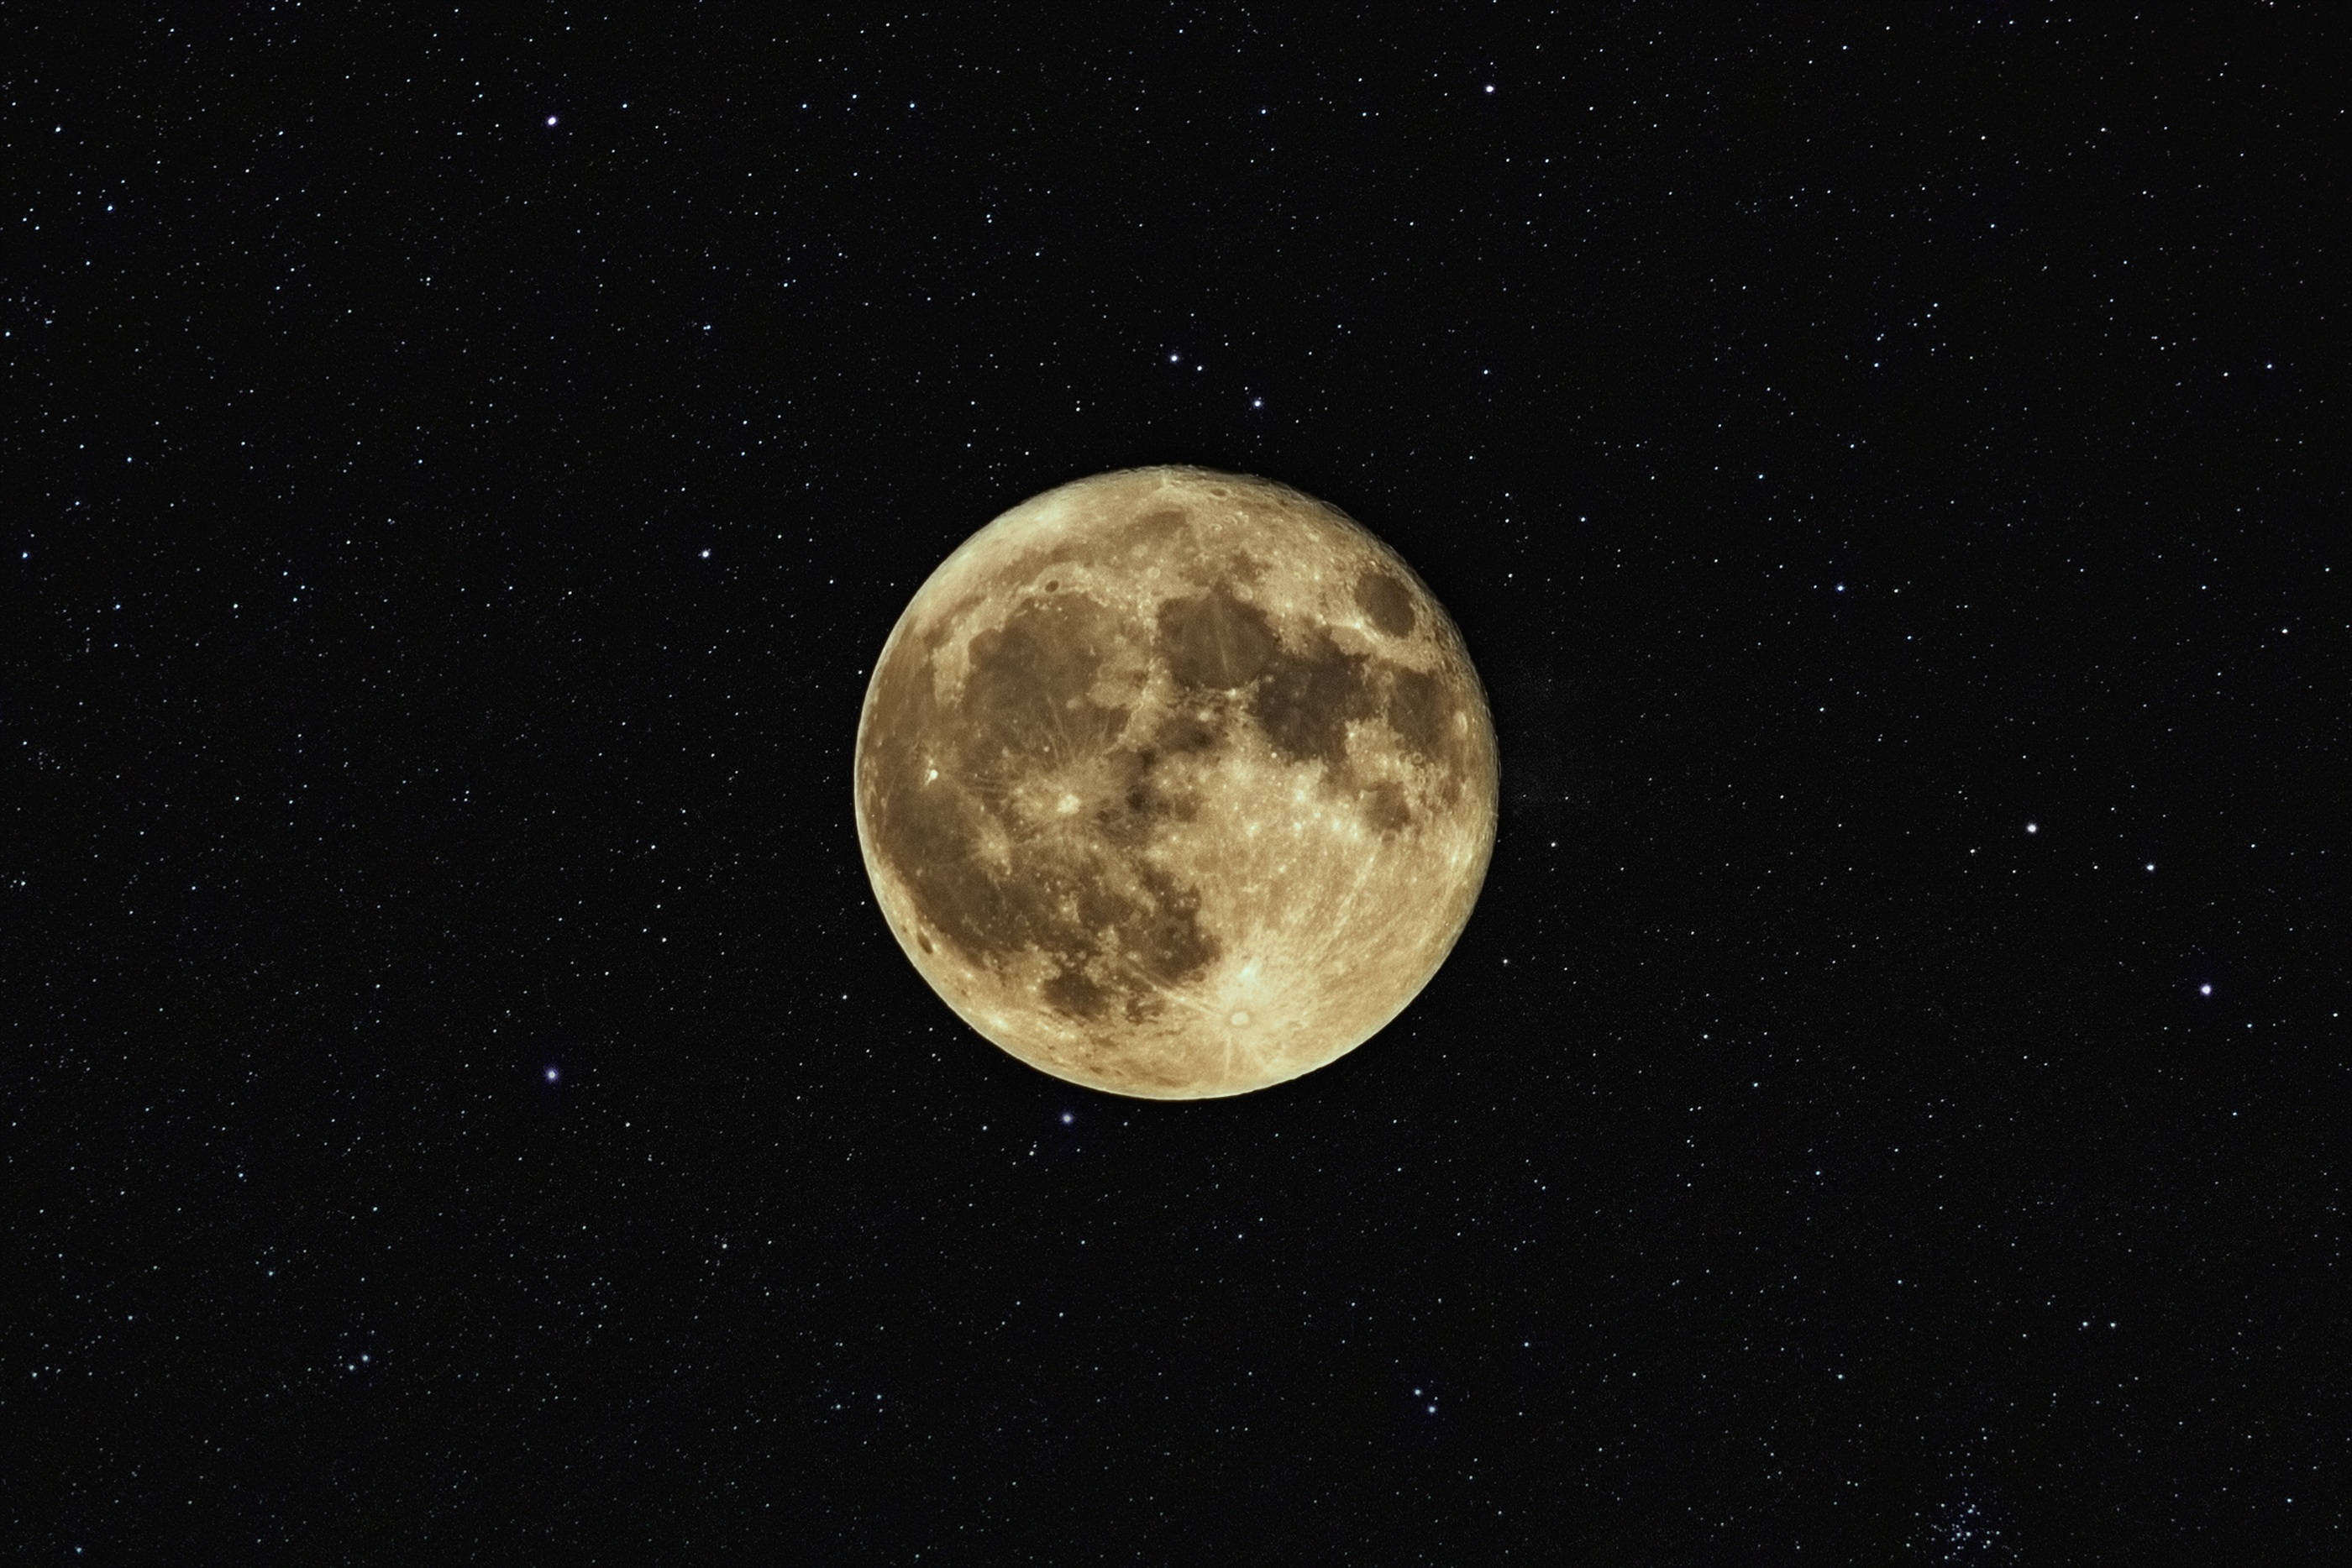

In [ ]:
from IPython.display import Image
Image(filename='./MobileNet-samples/4.jpg', width=300,height=200) 

In [ ]:
preprocessed_image = prepare_image('4.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
print(results)

[[('n04044716', 'radio_telescope', 0.5369115), ('n04258138', 'solar_dish', 0.062801994), ('n03691459', 'loudspeaker', 0.054491818), ('n02708093', 'analog_clock', 0.038091376), ('n03388043', 'fountain', 0.020083245)]]


我们可以看到MobileNet在图像分类方面做得非常出色。下一集我们将继续与MobileNet合作，我们将看到如何微调模型，并在新的数据集上使用迁移学习。

